# 事前準備

In [1]:
# ライブラリのインポート
import os
import random
from glob import glob
from warnings import filterwarnings

import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from collections import defaultdict

filterwarnings('ignore')  # warningをオフにする

In [2]:
# ランダムシードの設定
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# デバイスの設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {} # GPUが使える場合、DataLoaderでのミニバッチの取り出しを高速化
print(f'デバイス：{device}')

デバイス：cuda


In [4]:
# 画像データのディレクトリ
img_dir = '/kaggle/input/making-new-train-directory/train/' # 画像データのディレクトリ

# 学習済み
use_pretrained = True

# Model name
model_name = 'chest-xray-3cat-mobilenet_v3_large'

In [5]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--test_size', type=float, default=0.25)
parser.add_argument('--image_size', type=int, default=224)
parser.add_argument('--num_classes', type=int, default=3)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--lr', type=float, default=1e-4) # 学習率
parser.add_argument('--mode', type=str, default='max') # スケジューラの監視対象
parser.add_argument('--factor', type=float, default=0.5) # スケジューラの学習率を減衰させる割合
parser.add_argument('--lr_patience', type=int, default=5) # スケジューラの監視対象回数
parser.add_argument('--threshold', type=float, default=1e-5) # スケジューラの監視対象回数
parser.add_argument('--patience', type=int, default=20) # earlystoppingの監視対象回数
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=16, epochs=100, factor=0.5, image_size=224, lr=0.0001, lr_patience=5, mode='max', num_classes=3, patience=20, test_size=0.25, threshold=1e-05)


# データの読み込み

In [6]:
train_df = pd.read_csv('/kaggle/input/making-new-train-directory/train.csv')
print(train_df.head())
print('データ数: ', train_df.shape[0])

   Unnamed: 0                            name   label
0           0       NORMAL2-IM-0771-0001.jpeg  normal
1           1  NORMAL2-IM-1294-0001-0002.jpeg  normal
2           2               IM-0675-0001.jpeg  normal
3           3       NORMAL2-IM-1169-0001.jpeg  normal
4           4               IM-0421-0001.jpeg  normal
データ数:  5216


In [7]:
# ラベルの変更
train_df['label'] = train_df['label'].map({'normal': 0,
                                           'virus': 1,
                                           'bacteria': 2
})
print(train_df['label'].value_counts())

2    2530
1    1345
0    1341
Name: label, dtype: int64


In [8]:
# 画像データの名前リストの抽出
image_name_list = train_df['name'].values
print('データ数: ', len(image_name_list))

# ラベルリストの抽出
label_list = train_df['label'].values

データ数:  5216


# データの分割

In [9]:
# 学習データと検証データに分割
x_train, x_val, y_train, y_val = train_test_split(image_name_list, label_list, test_size=opt.test_size, stratify=label_list, random_state=42)

# 前処理

In [10]:
# transformの設定
transform = {
    'train': transforms.Compose([
        transforms.Resize((opt.image_size,opt.image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    'val': transforms.Compose([
        transforms.Resize((opt.image_size,opt.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
}

In [11]:
# Datasetの設定
class XrayDataset(Dataset):
    def __init__(self, image_name_list, label_list, img_dir, transform=None, phase=None):
        self.image_name_list = image_name_list # 画像ファイル名
        self.label_list = label_list # ラベル
        self.img_dir = img_dir # 画像データのディレクトリ
        self.phase = phase # 変数phaseで学習(train)もしくは検証(val)の設定を行う
        self.transform = transform

    def __len__(self):
        return len(self.image_name_list) # 1エポックあたりに読み込むデータ数として、入力データの数を指定

    def __getitem__(self, index):
        
        # index番目の画像を読み込み、前処理を行う
        image_path = os.path.join(self.img_dir, self.image_name_list[index]) # train_master.iloc[index, 0]はファイル名を抽出
        img = Image.open(image_path)
        img = self.transform[self.phase](img)
        
        # index番目のラベルを取得する
        label = self.label_list[index]
        
        return img, label

In [12]:
# Datasetのインスタンス作成
train_dataset = XrayDataset(x_train, y_train, img_dir, transform=transform, phase='train')
val_dataset = XrayDataset(x_val, y_val, img_dir, transform=transform, phase='val')

In [13]:
# Dataloader
dataloader = {
    'train': DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False)
}

In [14]:
train_iter = iter(dataloader['train'])
imgs, labels = train_iter.next()
print(imgs.size())
print(labels)

torch.Size([16, 3, 224, 224])
tensor([0, 1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2, 0])


# EarlyStopping

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

# モデルの定義

In [16]:
# 学習済みモデルの読み込み
model = models.mobilenet_v3_large(pretrained=use_pretrained)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [17]:
fc_in_features = model.classifier[0].out_features # 最終レイヤー関数の次元数
model.classifier[3] = nn.Linear(fc_in_features, opt.num_classes) # 最終レイヤー関数の付け替え
print(model)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

# Finetuning

In [18]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias",
                        "classifier.3.weight", "classifier.3.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

params_to_update_1に格納： features.0.0.weight
params_to_update_1に格納： features.0.1.weight
params_to_update_1に格納： features.0.1.bias
params_to_update_1に格納： features.1.block.0.0.weight
params_to_update_1に格納： features.1.block.0.1.weight
params_to_update_1に格納： features.1.block.0.1.bias
params_to_update_1に格納： features.1.block.1.0.weight
params_to_update_1に格納： features.1.block.1.1.weight
params_to_update_1に格納： features.1.block.1.1.bias
params_to_update_1に格納： features.2.block.0.0.weight
params_to_update_1に格納： features.2.block.0.1.weight
params_to_update_1に格納： features.2.block.0.1.bias
params_to_update_1に格納： features.2.block.1.0.weight
params_to_update_1に格納： features.2.block.1.1.weight
params_to_update_1に格納： features.2.block.1.1.bias
params_to_update_1に格納： features.2.block.2.0.weight
params_to_update_1に格納： features.2.block.2.1.weight
params_to_update_1に格納： features.2.block.2.1.bias
params_to_update_1に格納： features.3.block.0.0.weight
params_to_update_1に格納： features.3.block.0.1.weight
params_to_update

In [19]:
# モデルをGPUに送る
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

# 学習

In [20]:
# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=opt.lr, weight_decay=0.0001)

In [21]:
# 収束が停滞したら学習率を減衰するスケジューラー
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,   # オプティマイザーを指定
    mode=opt.mode,  # 監視対象は最大値
    factor=opt.factor,  # 学習率を減衰する割合
    patience=opt.lr_patience, # 監視対象のエポック数
    min_lr=opt.threshold, # 最小学習率
    verbose=True # 学習率を減衰した場合に通知する
)

In [22]:
# 学習履歴を保存するdictオブジェクト
history = defaultdict(list)

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=opt.patience, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力

# 学習モデルの定義
def train_model(model, epochs, loss_fn, optimizer):
    
    # ベストスコアの初期化
    best_loss = np.inf
    
    # エポックループの設定
    for epoch in range(epochs):
        
        # 現在のエポック数の出力
        print(f'Epoch: {epoch+1} / {epochs}')
        print('--------------------------')
        
         # 毎エポック: 学習・検証ループの設定
        for phase in ['train', 'val']:
            
            # 学習モード、検証モードの切替
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 損失値のリセット
            epoch_loss = 0.0
            # 正解数
            corrects = 0
            # 予測値リストのリセット
            pred_list = []
            # 正解値リストのリセット
            true_list = []
            
            # dataloaderから、ミニバッチ(batch_size)単位でのデータの読み込み
            for images, labels in dataloader[phase]:
                
                # 入力データ、正解ラベルをモデルと同じdeviceへ移動
                images = images.to(device)
                labels = labels.to(device)
                
                # 勾配情報の初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配情報を有効に
                with torch.set_grad_enabled(phase=='train'):
                    
                    # モデルによる計算
                    outputs = model(images)
                    # 損失値の計算
                    loss = loss_fn(outputs, labels)
                    # 予測ラベルの算出
                    preds = torch.argmax(outputs, dim=1) # 予測値を出力
                    
                    # 学習時のみ、バックプロパゲーションとパラメータ更新
                    if phase == 'train':
                        
                        # 誤差逆伝播法により勾配の算出
                        loss.backward()
                        # optimizerのパラメータ更新
                        optimizer.step()
                    
                    # 損失値の追加
                    epoch_loss += loss.item() * images.size(0)
                    
                    # 正解数の追加
                    corrects += torch.sum(preds == labels.data)                    
                    
                    # 予測ラベルの追加
                    preds = preds.to('cpu').numpy()
                    pred_list.extend(preds)
                    
                    # 正解ラベルの追加
                    labels = labels.to('cpu').numpy()
                    true_list.extend(labels)
            
            # 1エポック内における損失値の平均
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            
            # 正解率の算出
            accuracy = corrects.double() / len(dataloader[phase].dataset)
            accuracy = accuracy.to('cpu').detach().numpy().copy()
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(accuracy)
            
            # 各評価スコアの出力
            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}')
            
            # 検証時、検証スコアとベストスコアの大小比較を行う
            if (phase == 'val') and (epoch_loss < best_loss):
                
                ## 検証スコアが改善した場合のみ以下の処理を行う
                
                # ベストスコアの更新
                best_loss = epoch_loss
                # パラメータの名前を指定
                param_name = f'/kaggle/working/{model_name}.pth'
                # パラメータの保存
                torch.save(model.state_dict(), param_name)
        
        # スケジューラー、テストデータの精度を監視する
        scheduler.step(epoch_loss)

        # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
        if (phase == 'val') and ers(epoch_loss):
            # 監視対象のエポックで損失が改善されなければ学習を終了
            break

In [23]:
# モデルの学習と推論の実行
train_model(model, opt.epochs, criterion, optimizer)

Epoch: 1 / 100
--------------------------
train Loss: 0.6728 Accuracy: 0.7025
val Loss: 0.5099 Accuracy: 0.7753
Epoch: 2 / 100
--------------------------
train Loss: 0.5230 Accuracy: 0.7779
val Loss: 0.4487 Accuracy: 0.8090
Epoch: 3 / 100
--------------------------
train Loss: 0.5059 Accuracy: 0.7802
val Loss: 0.4409 Accuracy: 0.8160
Epoch: 4 / 100
--------------------------
train Loss: 0.4787 Accuracy: 0.7883
val Loss: 0.4045 Accuracy: 0.8305
Epoch: 5 / 100
--------------------------
train Loss: 0.4641 Accuracy: 0.7996
val Loss: 0.4016 Accuracy: 0.8344
Epoch: 6 / 100
--------------------------
train Loss: 0.4398 Accuracy: 0.8067
val Loss: 0.3910 Accuracy: 0.8382
Epoch: 7 / 100
--------------------------
train Loss: 0.4316 Accuracy: 0.8121
val Loss: 0.3903 Accuracy: 0.8367
Epoch     7: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 8 / 100
--------------------------
train Loss: 0.3925 Accuracy: 0.8254
val Loss: 0.3886 Accuracy: 0.8397
Epoch: 9 / 100
--------------------------


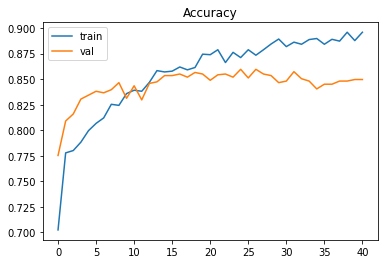

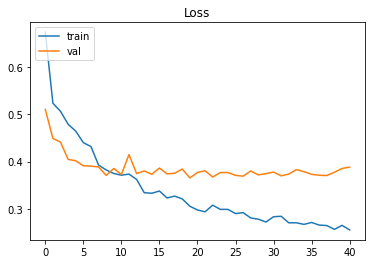

In [24]:
# 正解率の推移をプロット
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ロスの推移をプロット
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()